## Datastream Processing Lab 1: Kmeans on the SHealth dataset

Arpa MUKHERJEE

#### Datastream Parser

In [1]:
# Load and configure Spark

import findspark
findspark.init('C:\spark')
import pyspark
from pyspark import SparkContext

# Set Spark Configurations
conf = pyspark.SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '8G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G')
        .set('spark.yarn.executor.memoryOverhead', '2048MB')
        .set('spark.default.parallelism', '100'))
sc = SparkContext(conf=conf)

In [2]:
def parser(filename):
    
    reservoir = []
    
    rdd = sc.textFile(filename).map(lambda line: line.split(";")) 
    len_rdd = rdd.count() - 1
    feed = rdd.collect()
    
    for i in range(0, len_rdd): #len_rdd
        i += 1 # ignore header
        line = feed[i][1:8] # select columns (Date, Weight, Steps, Walk (min), Swimming (min), Other sports (min), Spent kcal)
        line[1]  = line[1].replace(',','.').strip('\'"') # formatting
        
        if '' in line:
            pass
        
        else:
            reservoir.append(line)
        
    return reservoir

#### Load Dataset

In [3]:
filename = "shealth.csv"
reservoir = parser(filename)
len(reservoir)

808

#### Kmeans Algorithm (original)

In [4]:
import numpy as np

class Kmeans:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                
                prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

#### Kmeans Algorithm (online adaptation)

In [4]:
import numpy as np
import pandas as pd

class stream_kmeans:
    
    def __init__(self, k, window):
        self.k = k
        self.window = window
        self.memory = []
        self.results = []
        
        
    def fit(self, line):
        
        # BUILD WINDOW

        self.memory.append(line)   
        
        self.memory_window = self.memory[-self.window:]
        
        
        # ASSIGN VARIABLES
        
        if len(self.memory_window) > self.k:
            
            self.centroids = {}
            self.classifications = {}
            
            for t, element in enumerate(self.memory_window):
                
                self.tdate = self.memory_window[t][0]
                self.v = self.memory_window[t][1:7] # latest datapoint
                self.featureset = np.asarray(self.v, dtype = float)  
                self.t = t+1
                
                #print('t:{}, len_memory:{}:'.format(self.t, len(self.memory)))

                if len(self.centroids) == 0:

                    for i in range(k):
                            self.centroids[i] = np.asarray(self.memory_window[i][1:7], dtype = float)
                            self.classifications[i] = []

                self.prev_centroids = self.centroids
                #print('prev {}'.format(self.prev_centroids))


                # CLASSIFICATION

                distances = [np.linalg.norm(self.featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(self.featureset)

                array = [self.tdate, self.t, self.featureset, classification, min(distances), self.centroids[classification]]   
                self.results.append(array)
                
                #print('results {}'.format(array))

                # UPDATE CENTROID

                for classification in self.classifications:          

                    m =  self.prev_centroids[classification]

                    datapoint = self.featureset

                    updated_centroid = m + (1/self.t)*(datapoint - m)

                    self.centroids[classification] = updated_centroid
                    
                #print('updated {}'.format(self.centroids))


        current_results = self.results[-self.window:]

        results_hist = self.results

        return results_hist, current_results


#### Run streaming K-means

In [5]:
# Set parameters
k = 2
w = 100
clf = stream_kmeans(k=k, window=w)
print("{} clusters, consider a sliding window of {} datapoints in the stream".format(k, w))

# Run classifier over streaming data

for line in reservoir:

    results_hist, current_results = clf.fit(line)

2 clusters, consider a sliding window of 100 datapoints in the stream


#### Results

In [15]:
print('length current results {}:, length results history: {}'.format(len(current_results), len(results_hist)))

length current results 100:, length results history: 75847


In [6]:
res_window = pd.DataFrame(current_results)
res_window.columns=['tdate','t', 'featureset', 'classification', 'distance', 'closest_centroid']
res_window.tail()

,tdate,t,featureset,classification,distance,closest_centroid
95,01/08/2017,96,"[74.4, 8183.0, 76.0, 0.0, 1.0, 360.0]",0,1343.315881,"[73.8263157895, 9521.50526316, 88.8947368421, ..."
96,02/08/2017,97,"[75.2, 6762.0, 61.0, 0.0, 16.0, 393.0]",0,2746.849835,"[73.8322916667, 9507.5625, 88.7604166667, 4.01..."
97,03/08/2017,98,"[74.1, 7848.0, 77.0, 0.0, 1.0, 336.0]",0,1636.861347,"[73.8463917526, 9479.25773196, 88.4742268041, ..."
98,04/08/2017,99,"[74.9, 18112.0, 161.0, 0.0, 2.0, 770.0]",0,8654.918324,"[73.8489795918, 9462.6122449, 88.3571428571, 3..."
99,05/08/2017,100,"[75.3, 6623.0, 60.0, 0.0, 2.0, 321.0]",0,2931.040556,"[73.8595959596, 9549.97979798, 89.0909090909, ..."


In [7]:
results_hist = pd.DataFrame(results_hist)
results_hist.columns = ['tdate', 't', 'featureset','classification', 'distance', 'closest_centroid']

# Convert centroid_array for plotting
results_hist['fcentroid'] = np.nan

for row in results_hist.index:
    
    v = 0.001
    
    weight = float(results_hist.closest_centroid[row][0])
    steps = float(results_hist.closest_centroid[row][1])
    spent_kcal = float(results_hist.closest_centroid[row][5])
    tot_mins = float(results_hist.closest_centroid[row][2])+float(results_hist.closest_centroid[row][3])+float(results_hist.closest_centroid[row][4])
    
    fc = weight/(steps + spent_kcal + tot_mins + v)
    
    fc = fc*1000 # scale with distance
    
    results_hist.set_value(row, 'fcentroid', fc)
    
results_hist.head(10)

,tdate,t,featureset,classification,distance,closest_centroid,fcentroid
0,20/05/2015,1,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",0,0.000000,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
1,21/05/2015,2,"[68.3, 8111.0, 70.0, 0.0, 11.0, 452.0]",0,1492.754169,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
2,22/05/2015,3,"[68.7, 9283.0, 85.0, 40.0, 0.0, 686.0]",0,1936.887935,"[68.35, 7365.5, 72.5, 0.0, 8.5, 416.0]",1017.398982
3,20/05/2015,1,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",0,0.000000,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
4,21/05/2015,2,"[68.3, 8111.0, 70.0, 0.0, 11.0, 452.0]",0,1492.754169,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
5,22/05/2015,3,"[68.7, 9283.0, 85.0, 40.0, 0.0, 686.0]",0,1936.887935,"[68.35, 7365.5, 72.5, 0.0, 8.5, 416.0]",1017.398982
6,23/05/2015,4,"[68.6, 5995.0, 53.0, 0.0, 0.0, 237.0]",0,2027.779852,"[68.4666666667, 8004.66666667, 76.6666666667, ...",859.534655
7,20/05/2015,1,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",0,0.000000,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
8,21/05/2015,2,"[68.3, 8111.0, 70.0, 0.0, 11.0, 452.0]",0,1492.754169,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.765870
9,22/05/2015,3,"[68.7, 9283.0, 85.0, 40.0, 0.0, 686.0]",0,1936.887935,"[68.35, 7365.5, 72.5, 0.0, 8.5, 416.0]",1017.398982


In [9]:
# Find index where first w points are completed
results_hist.loc[results_hist.t == w][0:1]

,tdate,t,featureset,classification,distance,closest_centroid,fcentroid
5046,27/08/2015,100,"[70.4, 8396.0, 74.0, 0.0, 0.0, 372.0]",0,1743.124712,"[69.1242424242, 6653.02020202, 62.202020202, 7...",1111.453655


In [10]:
# Find index of first full window start
results_hist[5046-w+1:5046-w+2]

,tdate,t,featureset,classification,distance,closest_centroid,fcentroid
4947,20/05/2015,1,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",0,0.0,"[68.4, 6620.0, 75.0, 0.0, 6.0, 380.0]",1034.76587


In [ ]:
# Locate dates based on index 
results_hist.loc[results_hist.index ==]

#### B2.3 Plots

#### Responses based on plots

B2.2 

The larger the k, it seems the data tend to be assigned to fewer clusters at first and then more evenly distributed with progression in time. For k=10, and the smaller windows = {100,250}, the algorithm failed to assign to any except the first cluster. For the smallest window size, however, the assignments seem to be biased to a particular cluster consistently also. It is only after more data points (window = 500) did it start clustering. There are a total of 810 data points in the dataset, so the windows were arbitrarily selected in respect to this number.  For the window size of 100, for all values of k there is a spike (lack of activity) corresponding to the date of 2017-04-23, but difficult to distinguish the variation. For the window size of 250, it is easier to see a contrast in lack of activity per user (indicated by spike) and activity (indicated by valleys). Based on window = 250 for all k clusters, around these dates (they vary slightly based on cluster size) are most active [2016-04-07, 2016-12-04], and around these dates there is less activity [2015-12-29, 2016-06-26, 2017-04-03] across all users. Based on window = 500 for k clusters (2,3), around these dates are most active[2016-04-10, 2016-08-18], and around these dates there is less activity [2016-05-20, 2016-10-17, 2016-11-27] across all users. Since the algorithm didn’t perform for k=10, window = 500 initially, data from there is not considered. 
 
B2.3

It is difficult to pick parameters that are robust and also fair in assignment to the clusters. Here, for this datastream, the median parameters of k=3, window = 250 seem to work best. A window size that is too small tends to be biased towards one cluster and highlight outliers. A window size that is too great is perhaps too random and it takes awhile for the data stream to learn and classify clusters fairly.

In [33]:
import matplotlib.pyplot as plt

df = results_hist[4947: len(results_hist)]
#df = results_hist[30873: len(results_hist)]
#df = results_hist[124248: len(results_hist)]
#df = results_hist[4747: len(results_hist)]
#df = results_hist[30622: len(results_hist)]
#df = results_hist[123747: len(results_hist)]
#df = results_hist[4895: len(results_hist)]
#df = results_hist[31070: len(results_hist)]
#df = results_hist[124695: len(results_hist)]


def c2plot(df):
    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['fcentroid']], color='g', label='class 0 centroid')
    ax.plot(df.loc[df['classification'] == 1, ['fcentroid']], color='r', label='class 1 centroid')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Centroid')
    plt.title('Centroids over time')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['distance']], color='g', label='class 0 distance')
    ax.plot(df.loc[df['classification'] == 1, ['distance']], color='r', label='class 1 distance')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Distance')
    plt.title('Distance over time')
    plt.show()
    
def c3plot(df):
    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['fcentroid']], color='g', label='class 0 centroid')
    ax.plot(df.loc[df['classification'] == 1, ['fcentroid']], color='r', label='class 1 centroid')
    ax.plot(df.loc[df['classification'] == 2, ['fcentroid']], color='b', label='class 2 centroid')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Centroid')
    plt.title('Centroids over time')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['distance']], color='g', label='class 0 distance')
    ax.plot(df.loc[df['classification'] == 1, ['distance']], color='r', label='class 1 distance')
    ax.plot(df.loc[df['classification'] == 2, ['distance']], color='b', label='class 2 distance')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Distance')
    plt.title('Distance over time')
    plt.show()
    
def c10plot(df):
    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['fcentroid']], color='g', label='class 0 centroid')
    ax.plot(df.loc[df['classification'] == 1, ['fcentroid']], color='r', label='class 1 centroid')
    ax.plot(df.loc[df['classification'] == 2, ['fcentroid']], color='b', label='class 2 centroid')
    ax.plot(df.loc[df['classification'] == 3, ['fcentroid']], color='y', label='class 3 centroid')
    ax.plot(df.loc[df['classification'] == 4, ['fcentroid']], color='#00FFFF', label='class 4 centroid')
    ax.plot(df.loc[df['classification'] == 5, ['fcentroid']], color='#FF00FF', label='class 5 centroid')
    ax.plot(df.loc[df['classification'] == 6, ['fcentroid']], color='#C0C0C0', label='class 6 centroid')
    ax.plot(df.loc[df['classification'] == 7, ['fcentroid']], color='#800000', label='class 7 centroid')
    ax.plot(df.loc[df['classification'] == 8, ['fcentroid']], color='#808000', label='class 8 centroid')
    ax.plot(df.loc[df['classification'] == 9, ['fcentroid']], color='#008000', label='class 9 centroid')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Centroid')
    ax.xticks(df.index, df.dates, rotation='vertical')
    plt.title('Centroids over time')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(df.loc[df['classification'] == 0, ['distance']], color='g', label='class 0 distance')
    ax.plot(df.loc[df['classification'] == 1, ['distance']], color='r', label='class 1 distance')
    ax.plot(df.loc[df['classification'] == 2, ['distance']], color='b', label='class 2 distance')
    ax.plot(df.loc[df['classification'] == 3, ['distance']], color='y', label='class 3 distance')
    ax.plot(df.loc[df['classification'] == 4, ['distance']], color='#00FFFF', label='class 4 distance')
    ax.plot(df.loc[df['classification'] == 5, ['distance']], color='#FF00FF', label='class 5 distance')
    ax.plot(df.loc[df['classification'] == 6, ['distance']], color='#C0C0C0', label='class 6 distance')
    ax.plot(df.loc[df['classification'] == 7, ['distance']], color='#800000', label='class 7 distance')
    ax.plot(df.loc[df['classification'] == 8, ['distance']], color='#808000', label='class 8 distance')
    ax.plot(df.loc[df['classification'] == 9, ['distance']], color='#008000', label='class 9 distance')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time')
    ax.set_ylabel('Distance')
    plt.title('Distance over time')
    plt.show()

#### k = 2, w = 100

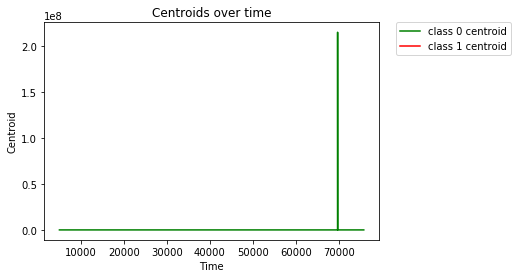

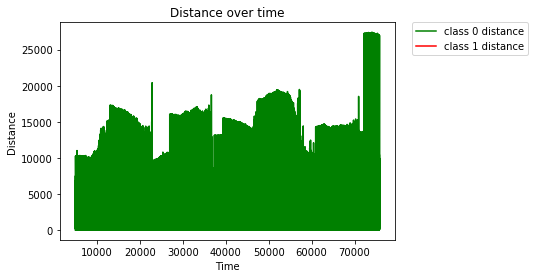

In [34]:
c2plot(df)

#### k = 2, window = 250

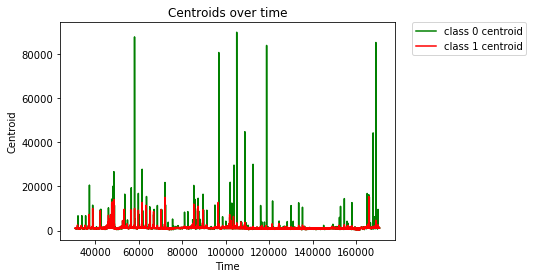

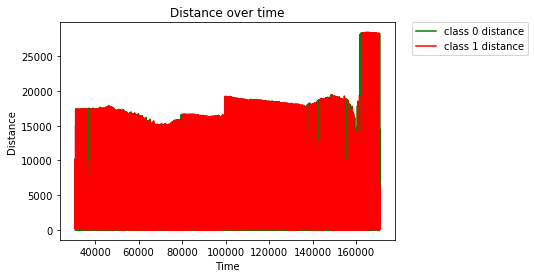

In [40]:
c2plot(df)

#### k = 2, window = 500

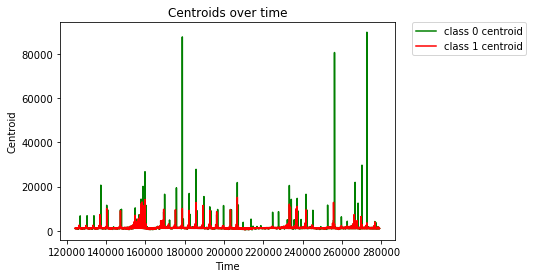

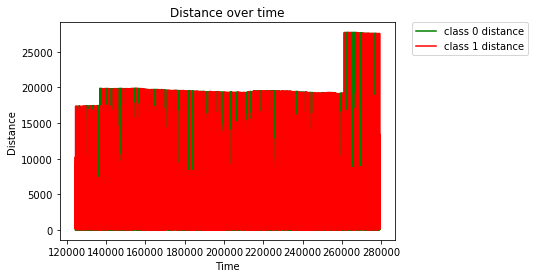

In [48]:
c2plot(df)

#### k = 3, window = 100

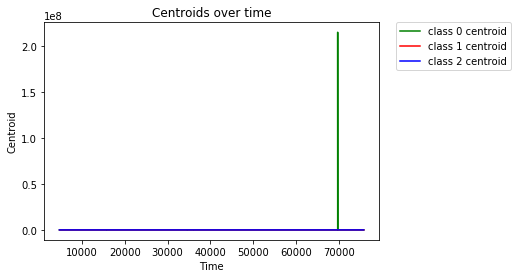

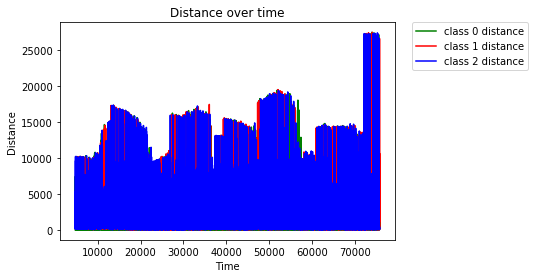

In [58]:
c3plot(df)

#### k = 3, window = 250

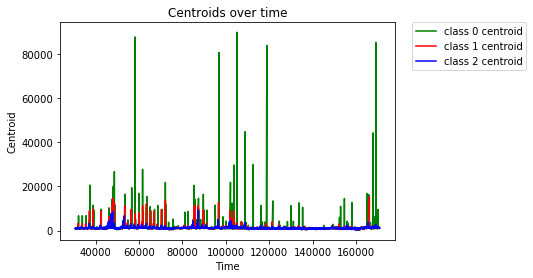

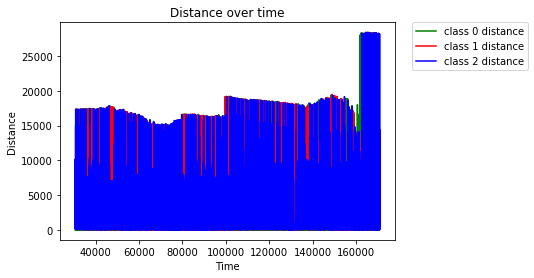

In [69]:
c3plot(df)

#### k = 3, window = 500

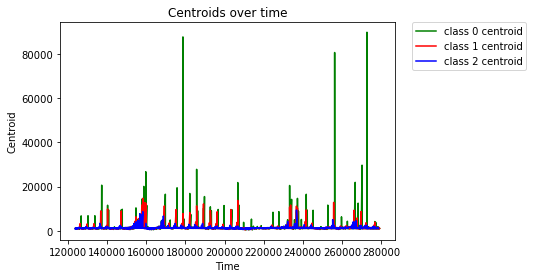

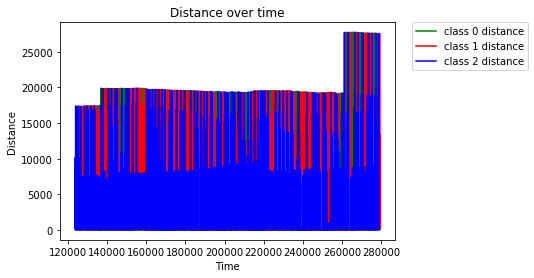

In [81]:
c3plot(df)

#### k = 10, window = 100

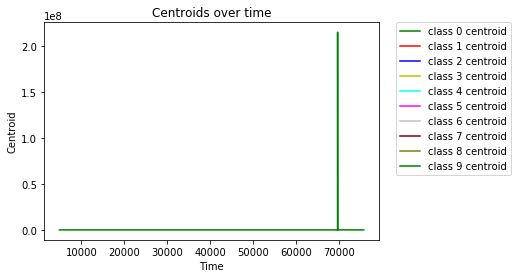

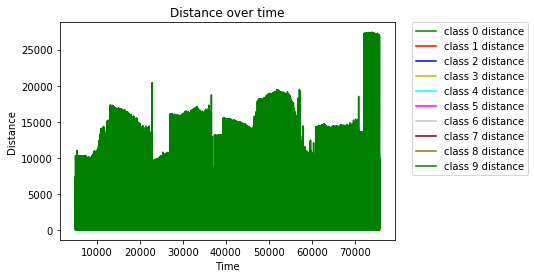

In [107]:
c10plot(df)

#### k = 10, window = 250

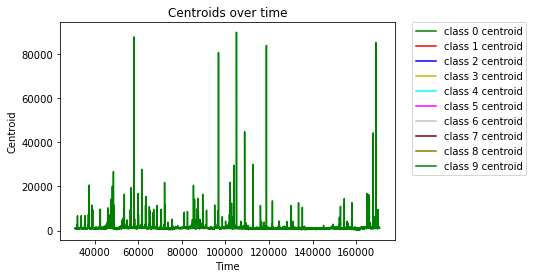

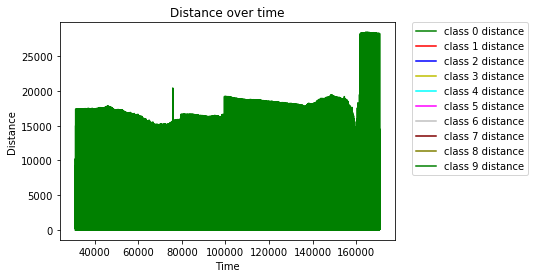

In [116]:
c10plot(df)

#### k = 10, window = 500

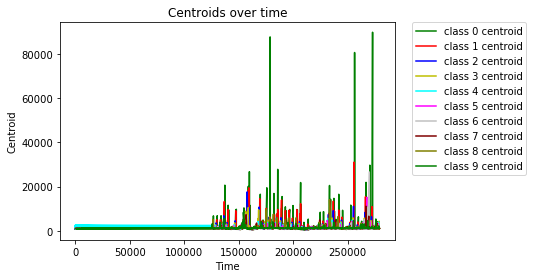

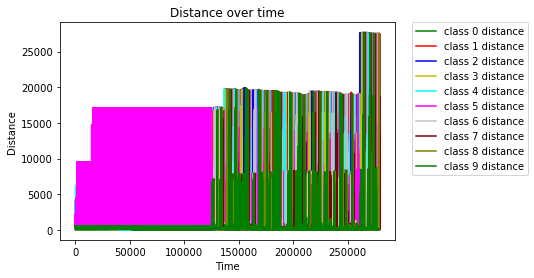

In [887]:
c10plot(df)

#### B2.4 Modification to update clusters

My approach was to average the minimum distance over time (dist_list) and create a centroid-datapoint if the distance was two standard deviations above. However, since the window is updating iteratively, each new datapoint is generally getting flagged in the beginning in the early stages, and would be too volatile if the window is small (too sensitive to changes). To remove clusters that have not been assigned for awhile is very difficult to determine a time t threshold especially for when k is small.

In [ ]:
import numpy as np
import pandas as pd

class stream_kmeans:
    
    def __init__(self, k, window):
        self.k = k
        self.window = window
        self.memory = []
        self.results = []
        self.dist_list = []
        
        
    def fit(self, line):
        
        # BUILD WINDOW

        self.memory.append(line)   
        
        self.memory_window = self.memory[-self.window:]
        
        
        # ASSIGN VARIABLES
        
        if len(self.memory_window) > self.k:
            
            self.centroids = {}
            self.classifications = {}
            
            for t, element in enumerate(self.memory_window):

                self.v = self.memory_window[t] # latest datapoint
                self.featureset = np.asarray(self.v, dtype = float)  
                self.t = t+self.k
                
                #print('t:{}, len_memory:{}:'.format(self.t, len(self.memory)))

                if len(self.centroids) == 0:

                    for i in range(k):
                            self.centroids[i] = np.asarray(self.memory_window[i], dtype = float)
                            self.classifications[i] = []

                self.prev_centroids = self.centroids
                #print('prev {}'.format(self.prev_centroids))


                # CLASSIFICATION       
                
                ###### MODIFICATION HERE ########
             
                distances = [np.linalg.norm(self.featureset-self.centroids[centroid]) for centroid in self.centroids]
                
                print('min: {}'.format(min(distances)))
                
                if min(distances) != 0:
                    high_end = np.mean(self.dist_list) + 2*np.std(self.dist_list)
                    low_end = np.mean(self.dist_list) - 2*np.std(self.dist_list)
                    print(high_end, low_end)

                    if min(distances) > high_end or min(distances) < low_end:
                        print('outlier datapoint, create new cluster')
                        self.centroids[self.k+1] = self.featureset              

                else:
            
                    classification = distances.index(min(distances))
                    self.classifications[classification].append(self.featureset)

                    array = [self.t, self.featureset, classification, min(distances), self.centroids[classification]]   
                    self.results.append(array)

                    dist = self.dist_list.append(min(distances))

                    #print('results {}'.format(array))

                    # UPDATE CENTROID

                    for classification in self.classifications:          

                        m =  self.prev_centroids[classification]

                        datapoint = self.featureset

                        updated_centroid = m + (1/self.t)*(datapoint - m)

                        self.centroids[classification] = updated_centroid

                    #print('updated {}'.format(self.centroids))


        current_results = self.results[-self.window:]

        results_hist = self.results

        return results_hist, current_results


#### B2.5 Cold-start problem

The cold start problem refers to, for a datastream, how to recommend the appropriate clusters without any previous information (and the problem of choosing initial centroids). In regular k-means for a fixed dataset, one has all the data in order to determine the means for the k clusters. For streaming data, the typical approach is to use the first k data points as centroids. For this streaming data, I already initialized the first k data points as the centroids. However, this is sensitive to the order of the data and may not be representative. While the formula updates the centroids with each new data point, the centroids move towards the center of values in the window, which assumes that data is randomly distributed and not necessarily a reflection of the datastream as a whole.